# Image classifier - vgg16

In [15]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pylab as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

SEED  = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [16]:
from typing import Literal

Phase = Literal["train", "test"]


class ImageTransform:
    def __init__(self, resize: int, mean: int, std: int):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        }

    def __call__(self, img, phase: Phase = "train"):
        return self.data_transform[phase](img)


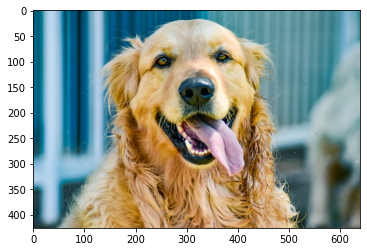

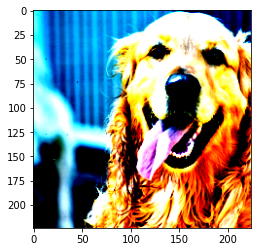

In [13]:
image_file_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (.485, .456, .406)
std = (.229, .224, .225)

tranform = ImageTransform(size, mean, std)
img_transformed = tranform(img, "train")

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)
plt.show()


In [17]:
def make_datapath_list(phase: Phase = "train") -> list[str]:
    root_path = "./data/hymenoptera_data/"
    target_path = osp.join(root_path+phase+"/**/*.jpg")
    print(target_path)

    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 './data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg',
 './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg',
 './data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg',
 './data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg',
 './data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg',
 './data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 './data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 './data/hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg',
 './data/hymenoptera_data/train/bees/2470492904_837e97800d.jpg',
 './data/hymenoptera_data/train/bees/2053200300_8911ef438a.jpg',
 './data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 './data/hymenoptera_data/train/bees/473618094_8ffdcab215.jpg',
 './data/hymenoptera_data/train/bees/150013791_969d9a968b.jpg',
 './data/hymenoptera_data/trai

In [21]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list: list[str], transform=None, phase: Phase="train"):
        self.file_list = file_list
        self.transform = tranform
        self.phase = phase

    def __len__(self):
        return len(self.file_list or [])
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label

train_dataset = HymenopteraDataset(file_list=train_list, transform=tranform, phase="train")
val_dataset = HymenopteraDataset(file_list=val_list, transform=tranform, phase="val")

index = 0
print(train_dataset[index][0].size())
print(train_dataset[index][1])

torch.Size([3, 224, 224])
1


In [22]:
batch_size = 32

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
imgs, labels = next(batch_iterator)
print(imgs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1])


In [23]:
net = models.vgg16(weights=models.VGG16_Weights)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

/opt/homebrew/Caskroom/miniforge/base/envs/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print("-" * 30)
print(params_to_update)

classifier.6.weight
classifier.6.bias
------------------------------
[Parameter containing:
tensor([[-0.0048,  0.0072, -0.0081,  ...,  0.0003, -0.0040,  0.0048],
        [ 0.0051,  0.0072, -0.0154,  ...,  0.0054,  0.0152,  0.0083]],
       requires_grad=True), Parameter containing:
tensor([ 0.0108, -0.0054], requires_grad=True)]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [29]:
def train_model(
    net: nn.Module, 
    dataloaders_dict: dict[str, data.DataLoader], 
    criterion: nn.modules.loss._Loss, 
    optimizer: optim.Optimizer, 
    num_epochs: int
):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("=" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            if epoch == 0 and phase == "train":
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print(f"{phase}:{epoch:3d} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

In [ ]:
num_epochs = 2
train_model(net, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

Epoch 1/2


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


val:  0 Loss: 0.6455, Acc: 0.5882
Epoch 2/2


100%|██████████| 8/8 [00:22<00:00,  2.79s/it]


train:  1 Loss: 0.4521, Acc: 0.7695


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

val:  1 Loss: 0.1767, Acc: 0.9477


In [44]:
import tempfile, os

MB = 1024 ** 2

def measure_model_size(model: nn.Module):
    memory_size = sum(parameter.numel() * parameter.element_size() for parameter in model.parameters())
    with tempfile.TemporaryFile(dir="/tmp", prefix="temp-model-") as temp_file:
        torch.save(model.state_dict(), temp_file)
        file_size = os.path.getsize(temp_file.name)
    
    return {"memory_size": f"{memory_size:,}", "file_size": f"{file_size:,}"}

In [45]:
result = measure_model_size(net)

print("양자화 전", result)

양자화 전 {'memory_size': '537,074,952', 'file_size': '537,085,558'}
